# Move video file to folder

In [30]:
import os
import glob
import shutil
import pathlib

for url in glob.glob(os.getcwd() + "/data/*.mp4"):
    fileName = os.path.basename(url).rsplit( ".", 1 )[ 0 ].replace('VID_', '')
    if(os.path.exists(url)):
        shutil.move(url, str(pathlib.Path().resolve()) + "\\data\\" + fileName)

# Compute orientation from Gyro

In [21]:
import csv
import math
import numpy as np
import cv2
from scipy import integrate
import matplotlib.pyplot as plt

def computeOrientation(fileName, displayGraph=False):
    gyroX, gyroY, gyroZ, time = [], [], [], []
    dt = 1/400 #400Hz

    data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
    orientation_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'orientation.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(orientation_file)

    t_init, t_final, counter = 0, 0, 0
    
    for row in data_reader:
        gyroX.append(float(row[0]))
        gyroY.append(float(row[1]))
        gyroZ.append(float(row[2]))
        time.append(int(row[3]))
        
        t_final = int(row[3])
        counter += 1
        if t_init == 0:
            t_init = int(row[3])


    x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
    X_int = integrate.cumtrapz(gyroX, dx=dt, initial=0)
    Y_int = integrate.cumtrapz(gyroY, dx=dt, initial=0)
    Z_int = integrate.cumtrapz(gyroZ, dx=dt, initial=0)

    if displayGraph:
        plt.plot(x, X_int*(180/math.pi), color="g", label="x")
        plt.plot(x, Y_int*(180/math.pi), color="r", label="y")
        plt.plot(x, Z_int*(180/math.pi), color="b", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('orientation (degree)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()


    for i in range(len(time)):
        writer.writerow([X_int[i]*(180/math.pi), Y_int[i]*(180/math.pi), Z_int[i]*(180/math.pi), time[i], gyroX[i], gyroY[i], gyroZ[i]])

    data_file.close()
    orientation_file.close()

## For specific file

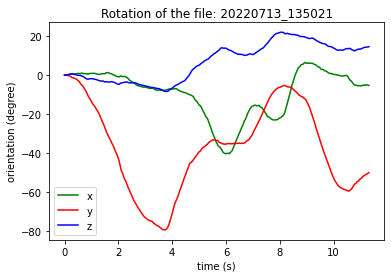

In [22]:
computeOrientation(fileName="20220713_135021", displayGraph=True)

## For entire dataset

In [25]:
import os 
import time
from IPython.display import clear_output

displayGraph = False

dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    computeOrientation(fileName=file, displayGraph=displayGraph)
    if displayGraph:
        time.sleep(1)
        os.system('clear')
        clear_output(wait=True)

# Sync orientation to video frame

In [37]:
import csv
import math
import numpy as np
import cv2

def processData(fileName, sensorType):

    time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
    data_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  +  sensorType + '.csv', 'r')
    data_processed = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_" + sensorType + '.csv',  'w+', newline="")

    time_reader = csv.reader(time_file)
    data_reader = csv.reader(data_file)

    writer = csv.writer(data_processed)
    writer.writerow(["Rot_X (deg)", "Rot_Y (deg)", "Rot_Z (deg)", "Gyro_Time (ns)", "Gyro_X", "Gyro_Y", "Gyro_Z"])

    """Loop through the time data file and the gyro file; Then add the ones in gyro that have closest timestamp to the timestamp file"""
    #Time list
    time_list = list(time_reader)
    frame_counter = 0

    """GYRO/ACC/MAG"""
    data_processed = list() #This will be the list we will export as a CSV
    data_set = set() #Only add matched timestamp here

    """First entry"""
    first_orientation = []

    for row in data_reader:
        if frame_counter == len(time_list):
            break

        target_time = int(time_list[frame_counter][0]) #This will get the target timestamp
        if len(data_processed) == 0:
            data_processed.append(row)
            continue
        
        #   If the current time from gyro_csv file has a smaller time difference than that in the
        #   data_processed list. Then we replace
        if (abs(int(row[3]) - target_time) < abs(int(data_processed[-1][3]) - target_time)):
            #Check set to see if previous time is already matched; We don't want it to be matched already
            if int(data_processed[-1][3]) not in data_set:
                #Replace with timestamp that has smaller time diff
                data_processed[-1] = row 
        else:
            #Add last element in the processed list to the data_set to confirm it's been matched
            frame_counter += 1
            data_set.add(int(data_processed[-1][3]))
            # orientation_row = [float(data_processed[-1][0]),float(data_processed[-1][1]),float(data_processed[-1][2])]
            orientation_row = np.array(data_processed[-1]).astype(float)
            if first_orientation == []:
                first_orientation = np.array(orientation_row)
            orientation_row[0] -= first_orientation[0]
            orientation_row[1] -= first_orientation[1]
            orientation_row[2] -= first_orientation[2]
            orientation_row[3] = data_processed[-1][3]
            orientation_row[4] = data_processed[-1][4]
            orientation_row[5] = data_processed[-1][5]
            orientation_row[6] = data_processed[-1][6]

            #Add this element to the CSV file as well
            writer.writerow(orientation_row)
            #Then add current row to data_processed
            data_processed.append(row)

    assert(len(data_processed)-1 == len(time_list))

    time_file.close()
    data_file.close()


## For specific file

In [38]:
processData(fileName="20220713_090357", sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## For entire dataset

In [39]:
import os 
import time
from IPython.display import clear_output


dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    processData(fileName=file, sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# Check orientation-to-frame accuracy

In [13]:
import numpy as np
fileName = "20220713_090421"

time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
sync_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_orientation.csv",  'r')

time_reader = csv.reader(time_file)
sync_reader = csv.reader(sync_file)

time_list = list(time_reader)
sync_list = list(sync_reader)[1:]

maxVal = -np.infty
minVal = np.infty

for i in range(len(time_list)):
    diff = float(time_list[i][0]) - float(sync_list[i][3])
    maxVal = max(diff, maxVal)
    minVal = min(diff, minVal)

print("Max offset error: " + str(maxVal/1e6) + "ms")
print("Min offset error: " + str(minVal/1e6) + "ms")

Max offset error: 1.210829ms
Min offset error: -1.225291ms


# Visualize

In [32]:
import test2
test2.func2()

Function 2 is active


In [1]:
import visualize
visualize.main(fileName="20220713_114353")

pygame 2.1.2 (SDL 2.0.18, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
fps: 28


NameError: name 'exit' is not defined